In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

In [2]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


In [3]:
# Base features
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)

# Extra features (your choice)
df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)
df['roll_max_10'] = df['ret'].rolling(10).max().shift(1)

# Targets
df['y_next_ret'] = df['ret'].shift(-1)   # forecasting
df['y_up'] = (df['y_next_ret'] > 0).astype(int)  # classification
df_feat = df.dropna().copy()


In [4]:
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5','roll_vol_20','roll_max_10']
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']


Forecasting RMSE: 0.014449555206255167


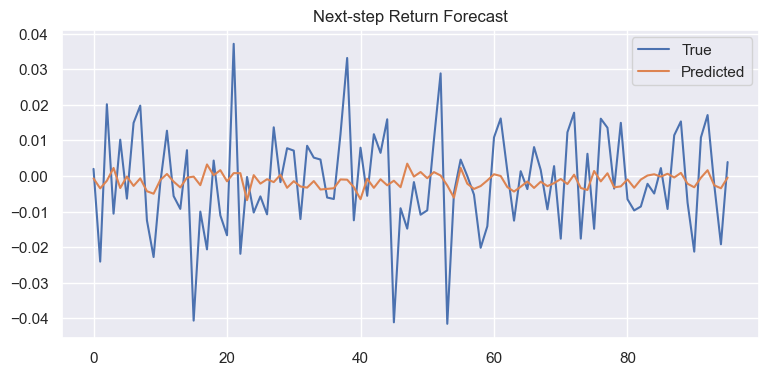

In [6]:
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)

rmse = mean_squared_error(y_te_reg, pred) ** 0.5
print('Forecasting RMSE:', rmse)

plt.plot(y_te_reg.values, label='True')
plt.plot(pred, label='Predicted')
plt.legend(); plt.title('Next-step Return Forecast'); plt.show()


              precision    recall  f1-score   support

           0       0.55      0.72      0.62        53
           1       0.44      0.28      0.34        43

    accuracy                           0.52        96
   macro avg       0.50      0.50      0.48        96
weighted avg       0.50      0.52      0.50        96



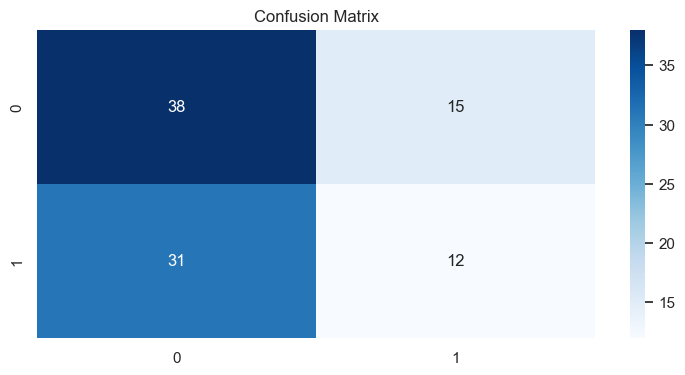

In [7]:
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)

print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


### Interpretation

- **Forecasting**:
  - RMSE ≈ 0.014 → average error about 1.4% per step.
  - The model captures some patterns from lag/rolling features, but jumps and volatility shifts remain unpredictable.
  - Reasonable baseline, but not strong enough for trading use.

- **Classification**:
  - Accuracy ≈ 52% (close to random).
  - Better at predicting down days (recall 0 = 0.72) than up days (recall 1 = 0.28).
  - Indicates weak predictive signal: lag/rolling features alone don’t separate up vs down well.

- **Assumptions and risks**:
  - Financial returns are noisy and heteroscedastic → violates linear model assumptions.
  - Lag structure is weak in real markets.
  - Small feature set limits performance.
